In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

os.environ['CUDA_VISIBLE_DEVICES']="1"


from keras.layers import Dense, Input
from keras.models import Model

import omnifold6b as of

import tensorflow as tf


In [2]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )
print("  tensorflow version:  %s" % str(tf.__version__))
print("\n\n")




  numpy version:  1.21.5
  tensorflow version:  2.11.0





## Set model and resolution parameters

In [3]:
ndim = 4



train_mu = [ 1.,  0.,  -0.5,   0.5 ]

train_rho = [ 
              [0.3, -0.2, 0.1   ],  #0
              [-0.5, 0.1],  #1
              [0.7],  #2
            ]

train_sig = [ 1., 0.7, 1.1, 0.8 ]





true_mu = [ 0.8,  0.1,  -0.6, 0.7 ]


true_rho  = [ 
              [0.4, -0.3, 0.0   ],  #0
              [-0.4, 0.2],  #1
              [0.5],  #2
            ]





true_sig = [ 0.8, 0.6, 1.0,    0.6 ]




resolution = [ 0.4, 0.5, 0.6,   0.3  ]




train_cov = np.zeros( shape=(ndim,ndim) )
true_cov  = np.zeros( shape=(ndim,ndim) )

print("\n\n\n Train covariance:")

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            train_cov[i][j] = train_sig[i] * train_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, train_cov[i][j]))
        else :
            k = ndim - j - 1
            train_cov[i][j] = train_sig[i] * train_sig[j] * train_rho[i][k]
            train_cov[j][i] = train_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, train_sig[i], train_sig[j], train_rho[i][k], train_cov[i][j]))
            
            

print("\n\n\n True covariance:")  

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            true_cov[i][j] = true_sig[i] * true_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, true_cov[i][j]))
        else :
            k = ndim - j - 1
            true_cov[i][j] = true_sig[i] * true_sig[j] * true_rho[i][k]
            true_cov[j][i] = true_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, true_sig[i], true_sig[j], true_rho[i][k], true_cov[i][j]))
            
            
                

                
                
ngen_train = 100000
ngen_true =  10000



ngen_train = 1000000
ngen_true =  100000


ngen_train = 4000000
ngen_true =  400000



#of_niter = 6
of_niter = 24

learning_rate_setval = 0.0005

#epochs_setval = 20
epochs_setval = 40

batch_size_setval = int( ngen_true )



output_dir = 'toy-study6b-4d'

save_step2_model = True





 Train covariance:
   0,  0 : diagonal    1.0000
   0,  1 :              1.000 *    0.700 *    0.100 =   0.0700
   0,  2 :              1.000 *    1.100 *   -0.200 =  -0.2200
   0,  3 :              1.000 *    0.800 *    0.300 =   0.2400
   1,  1 : diagonal    0.4900
   1,  2 :              0.700 *    1.100 *    0.100 =   0.0770
   1,  3 :              0.700 *    0.800 *   -0.500 =  -0.2800
   2,  2 : diagonal    1.2100
   2,  3 :              1.100 *    0.800 *    0.700 =   0.6160
   3,  3 : diagonal    0.6400



 True covariance:
   0,  0 : diagonal    0.6400
   0,  1 :              0.800 *    0.600 *    0.000 =   0.0000
   0,  2 :              0.800 *    1.000 *   -0.300 =  -0.2400
   0,  3 :              0.800 *    0.600 *    0.400 =   0.1920
   1,  1 : diagonal    0.3600
   1,  2 :              0.600 *    1.000 *    0.200 =   0.1200
   1,  3 :              0.600 *    0.600 *   -0.400 =  -0.1440
   2,  2 : diagonal    1.0000
   2,  3 :              1.000 *    0.600 *    0.500 = 

In [4]:
try:
    os.mkdir( output_dir )
except:
    print('\n\n Output directory already exists:  %s' % output_dir)
    print('\n\n HALTING EXECUTION\n\n')
    sys.exit()

In [5]:
print("\n\n")
print("Train covariance determinant:  %f" % np.linalg.det( train_cov ) )
print("True covariance determinant:   %f" % np.linalg.det( true_cov ) )
print("\n\n")




Train covariance determinant:  -0.032785
True covariance determinant:   0.008427





In [6]:
train_cov_inv = np.linalg.inv( train_cov )

In [7]:
train_cov_inv_test = np.matmul( train_cov, train_cov_inv )

In [8]:
print("\n\n")
print(" Train covariance")
print( train_cov )
print("\n Train covariance inverse")
print( train_cov_inv )
print("\n Train covariance inverse test")
print(train_cov_inv_test)
print("\n\n")




 Train covariance
[[ 1.     0.07  -0.22   0.24 ]
 [ 0.07   0.49   0.077 -0.28 ]
 [-0.22   0.077  1.21   0.616]
 [ 0.24  -0.28   0.616  0.64 ]]

 Train covariance inverse
[[ -2.08333333   5.15873016  -4.41919192   7.29166667]
 [  5.15873016  -6.99168556   7.6960077  -12.40079365]
 [ -4.41919192   7.6960077   -5.93051729  10.73232323]
 [  7.29166667 -12.40079365  10.73232323 -16.92708333]]

 Train covariance inverse test
[[ 1.00000000e+00  2.16722583e-16  4.55348441e-16  8.23415410e-18]
 [-1.62555155e-16  1.00000000e+00  1.85452103e-16 -9.14939421e-16]
 [-7.47513162e-16  2.23786069e-15  1.00000000e+00  1.42849621e-15]
 [-1.70234197e-17  5.18597511e-16 -1.57629241e-16  1.00000000e+00]]





In [9]:
true_cov_inv = np.linalg.inv( true_cov )

In [10]:
true_cov_inv_test = np.matmul( true_cov, true_cov_inv )

In [11]:
print("\n\n")
print(" True covariance")
print( true_cov )
print("\n True covariance inverse")
print( true_cov_inv )
print("\n True covariance inverse test")
print(true_cov_inv_test)
print("\n\n")




 True covariance
[[ 0.64   0.    -0.24   0.192]
 [ 0.     0.36   0.12  -0.144]
 [-0.24   0.12   1.     0.3  ]
 [ 0.192 -0.144  0.3    0.36 ]]

 True covariance inverse
[[  7.22810039  -6.56167979   5.95472441 -11.44192913]
 [ -6.56167979  10.38932633  -6.82414698  13.34208224]
 [  5.95472441  -6.82414698   6.69291339 -11.48293963]
 [-11.44192913  13.34208224 -11.48293963  23.78608924]]

 True covariance inverse test
[[ 1.00000000e+00  1.06931087e-17  3.84294521e-18  6.20869935e-16]
 [-1.08503102e-16  1.00000000e+00  5.03893806e-16 -5.79643362e-16]
 [-4.05876120e-16  5.62415867e-16  1.00000000e+00 -4.41714323e-16]
 [-6.64687028e-16 -3.56436956e-17 -3.08869291e-16  1.00000000e+00]]





## Plots to visualize these parameter choices

In [12]:


train_pts = np.random.multivariate_normal(train_mu, train_cov, size=ngen_train)
true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)

train_det_pts = np.random.normal( train_pts, resolution )

true_det_pts = np.random.normal( true_pts, resolution )



/tmp/ipykernel_217100/1918166166.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  train_pts = np.random.multivariate_normal(train_mu, train_cov, size=ngen_train)


In [13]:
with open( '%s/train-and-true-samples.npy' % output_dir, 'wb') as f :
    np.save(f, train_pts)
    np.save(f, train_det_pts)
    np.save(f, true_pts)
    np.save(f, true_det_pts)

In [14]:
with open( '%s/config-pars.npy' % output_dir , 'wb' ) as f :
    np.save( f, train_mu )
    np.save( f, train_rho )
    np.save( f, train_sig )
    np.save( f, true_mu )
    np.save( f, true_rho )
    np.save( f, true_sig )
    np.save( f, resolution )
    np.save( f, train_cov )
    np.save( f, true_cov )

/usr/lib/python3/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [15]:
config_filename = '%s/config.txt' % output_dir

config_file = open( config_filename, 'w' )

config_file.write('%s\n\n' % datetime.now() )
config_file.write('ngen_train %d\n' % ngen_train )
config_file.write('ngen_true  %d\n' % ngen_true )
config_file.write('of_niter   %d\n' % of_niter )
config_file.write('ndim       %d\n' % ndim )
config_file.write('learning_rate_setval  %f\n' % learning_rate_setval )
config_file.write('epochs_setval  %d\n' % epochs_setval )
config_file.write('batch_size_setval  %d\n' % batch_size_setval )


config_file.write('\n\n')
config_file.write('train_mu : %s\n' % str(train_mu))
config_file.write('train_rho : %s\n' % str(train_rho))
config_file.write('train_sig : %s\n' % str(train_sig))
config_file.write('train_cov : %s\n' % str(train_cov))
config_file.write('\n\n')
config_file.write('true_mu : %s\n' % str(true_mu))
config_file.write('true_rho : %s\n' % str(true_rho))
config_file.write('true_sig : %s\n' % str(true_sig))
config_file.write('true_cov : %s\n' % str(true_cov))
config_file.write('\n\n')
config_file.write('resolution : %s\n' % str(resolution) )
config_file.close()

print('\n\n  Config file contents : %s\n' % config_filename )
print( subprocess.getoutput('cat %s' % config_filename ))
print('\n\n')





  Config file contents : toy-study6b-4d/config.txt

2023-12-08 14:34:47.446593

ngen_train 4000000
ngen_true  400000
of_niter   24
ndim       4
learning_rate_setval  0.000500
epochs_setval  40
batch_size_setval  400000


train_mu : [1.0, 0.0, -0.5, 0.5]
train_rho : [[0.3, -0.2, 0.1], [-0.5, 0.1], [0.7]]
train_sig : [1.0, 0.7, 1.1, 0.8]
train_cov : [[ 1.     0.07  -0.22   0.24 ]
 [ 0.07   0.49   0.077 -0.28 ]
 [-0.22   0.077  1.21   0.616]
 [ 0.24  -0.28   0.616  0.64 ]]


true_mu : [0.8, 0.1, -0.6, 0.7]
true_rho : [[0.4, -0.3, 0.0], [-0.4, 0.2], [0.5]]
true_sig : [0.8, 0.6, 1.0, 0.6]
true_cov : [[ 0.64   0.    -0.24   0.192]
 [ 0.     0.36   0.12  -0.144]
 [-0.24   0.12   1.     0.3  ]
 [ 0.192 -0.144  0.3    0.36 ]]


resolution : [0.4, 0.5, 0.6, 0.3]





<function matplotlib.pyplot.show(close=None, block=None)>

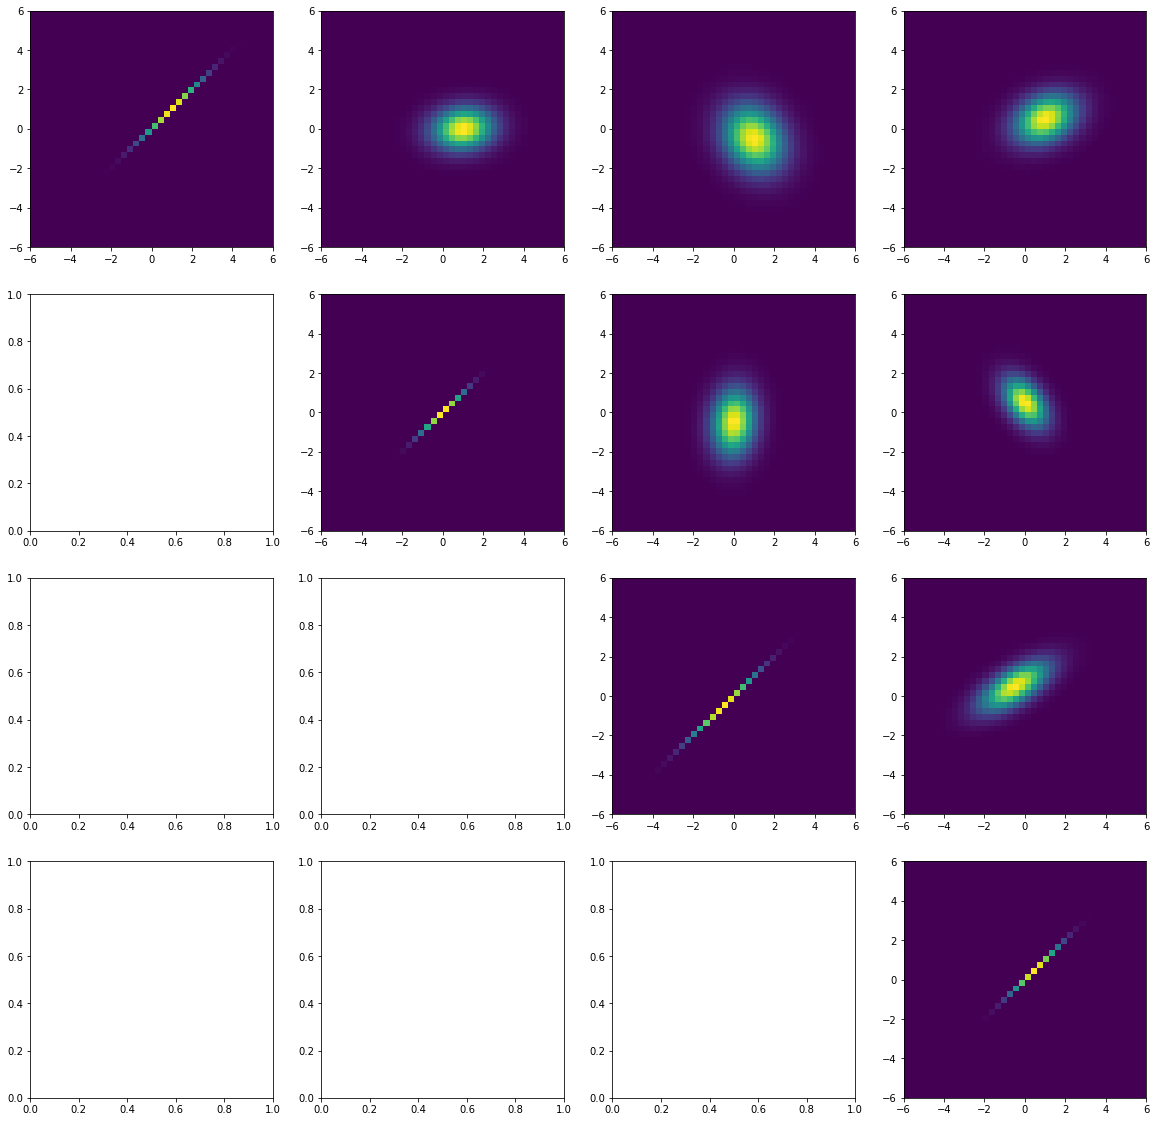

In [16]:
fig,ax = plt.subplots( 4, 4, figsize=(20,20))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        ax[i][j].hist2d( train_pts[:,i], train_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

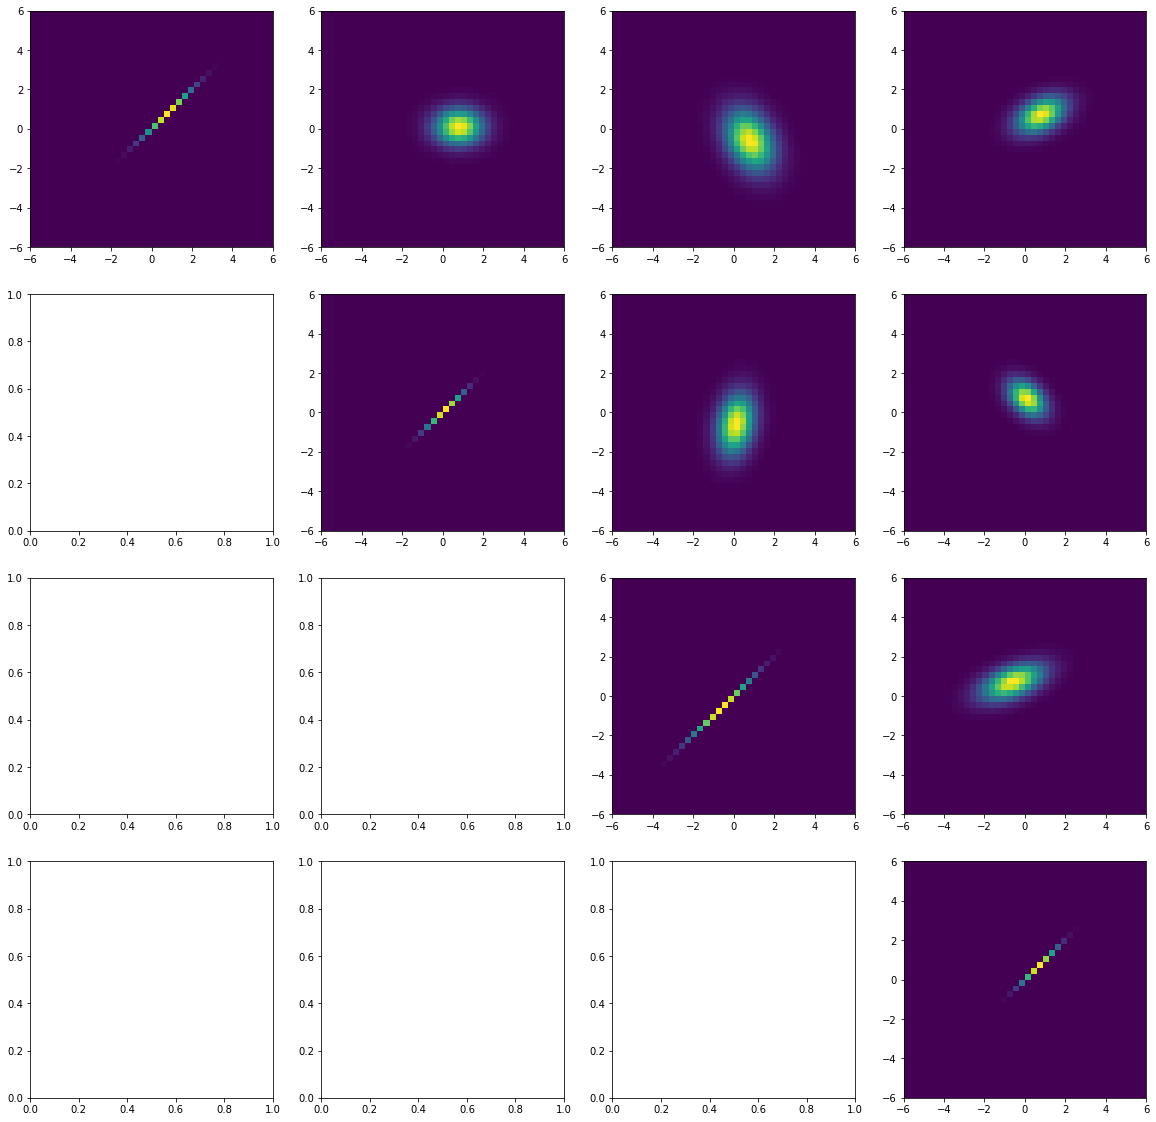

In [17]:
fig,ax = plt.subplots( 4, 4, figsize=(20,20))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        ax[i][j].hist2d( true_pts[:,i], true_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

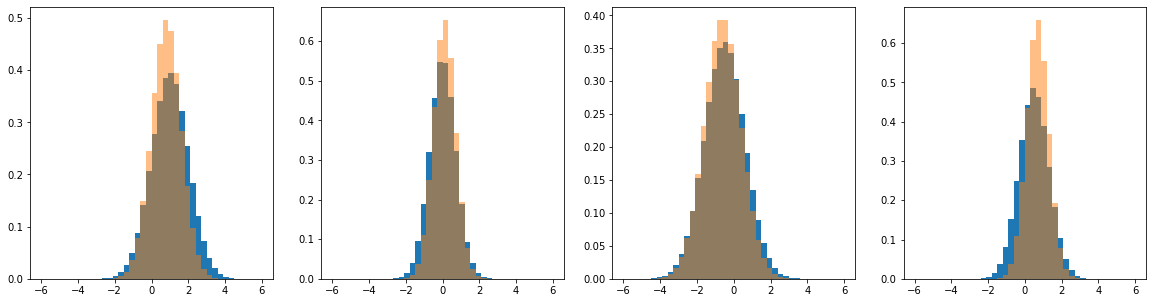

In [18]:
fig,ax = plt.subplots( 1, 4, figsize=(20,5))

hmin=-6
hmax=6
hbins=40


for i in range(ndim) :
        k = i*3 + j
        ax[i].hist( train_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        ax[i].hist( true_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

## Set up NN model for OmniFold

In [19]:
inputs = Input((4, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model = Model(inputs=inputs, outputs=outputs)

2023-12-08 14:34:51.770877: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-08 14:34:51.795916: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-08 14:34:51.796215: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-08 14:34:51.800475: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-08 14:34:51.800721: I tensorflow/compiler/xla/stream_executo

## Package the training data for OmniFold

In [20]:
train_both = np.stack([train_pts, train_det_pts], axis=1)

## Run OmniFold

In [21]:
%%time


verbose = True






of_return_dict = of.omnifold6b( 
    train_both, true_det_pts, of_niter, model, verbose, 
    batch_size_setval, learning_rate_setval, epochs_setval,
    save_step2_model, output_dir
)

of_weights = of_return_dict["weights"]

mc_weight_sf = (1.*len(true_det_pts))/(1.*len(train_both))

push_weights = of_return_dict["push_weights"]
push_weights_scaled = np.copy( push_weights )
push_weights_scaled = mc_weight_sf * push_weights

final_push_weights = of_return_dict["final_push_weights"]
final_push_weights_scaled = np.copy(final_push_weights)
final_push_weights_scaled = mc_weight_sf * final_push_weights

with open( '%s/omnifold-output-weights.npy' % output_dir, 'wb') as f :
    np.save(f, final_push_weights_scaled)





  ======== omnifold6


  shape of theta0_S : (4000000, 4)
  shape of theta_unknown_S : (400000, 4)
  shape of xvals_1 :  (4400000, 4)



  shape of labels0 : (4000000,)
  shape of labels_unknown : (400000,)
  shape of yvals_1 :  (4400000,)



  shape of theta0_G : (4000000, 4)
  shape of xvals_2 :  (8000000, 4)
  shape of yvals_2 :  (8000000,)

 batch size setval  400000
 learning rate setval  0.000500
 epochs setval  40




ITERATION: 1

   -- ITERATION 1  STEP 1

 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
             running pre-training, distinguish from self.
Epoch 1/5


2023-12-08 14:34:56.181903: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-08 14:34:56.186093: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fe518cf3740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-08 14:34:56.186107: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-12-08 14:34:56.190086: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-08 14:34:56.287894: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/15 [==============================] - 2s 8ms/step - loss: 0.6934 - accuracy: 0.4903
Epoch 2/5
15/15 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.4840
Epoch 3/5
15/15 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.4883
Epoch 4/5
15/15 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.4695
Epoch 5/5
15/15 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.5187
             done pretraining.
Epoch 1/80
9/9 [==============================] - 1s 28ms/step - loss: 0.1253 - accuracy: 0.4091 - val_loss: 0.1241 - val_accuracy: 0.4367
Epoch 2/80
9/9 [==============================] - 0s 13ms/step - loss: 0.1229 - accuracy: 0.4156 - val_loss: 0.1213 - val_accuracy: 0.3822
Epoch 3/80
9/9 [==============================] - 0s 13ms/step - loss: 0.1200 - accuracy: 0.3714 - val_loss: 0.1182 - val_accuracy: 0.3658
Epoch 4/80
9/9 [==============================] - 0s 14ms/step - loss: 0.1170

Epoch 56/80
9/9 [==============================] - 0s 16ms/step - loss: 0.1112 - accuracy: 0.3418 - val_loss: 0.1113 - val_accuracy: 0.3416
Epoch 57/80
9/9 [==============================] - 0s 13ms/step - loss: 0.1112 - accuracy: 0.3416 - val_loss: 0.1113 - val_accuracy: 0.3456
Epoch 58/80
9/9 [==============================] - 0s 15ms/step - loss: 0.1112 - accuracy: 0.3429 - val_loss: 0.1113 - val_accuracy: 0.3449
Epoch 59/80
9/9 [==============================] - 0s 14ms/step - loss: 0.1112 - accuracy: 0.3425 - val_loss: 0.1113 - val_accuracy: 0.3409
Epoch 60/80
9/9 [==============================] - 0s 14ms/step - loss: 0.1111 - accuracy: 0.3421 - val_loss: 0.1113 - val_accuracy: 0.3428
Epoch 61/80
9/9 [==============================] - 0s 14ms/step - loss: 0.1112 - accuracy: 0.3424 - val_loss: 0.1113 - val_accuracy: 0.3432
Epoch 62/80
9/9 [==============================] - 0s 14ms/step - loss: 0.1111 - accuracy: 0.3419 - val_loss: 0.1113 - val_accuracy: 0.3457
Epoch 63/80
9/9 [===

15/15 [==============================] - 0s 12ms/step - loss: 0.6687 - accuracy: 0.3794 - val_loss: 0.6691 - val_accuracy: 0.3800
Epoch 30/80
15/15 [==============================] - 0s 11ms/step - loss: 0.6687 - accuracy: 0.3794 - val_loss: 0.6691 - val_accuracy: 0.3800
Epoch 31/80
15/15 [==============================] - 0s 11ms/step - loss: 0.6687 - accuracy: 0.3794 - val_loss: 0.6690 - val_accuracy: 0.3800
Epoch 32/80
15/15 [==============================] - 0s 11ms/step - loss: 0.6687 - accuracy: 0.3795 - val_loss: 0.6690 - val_accuracy: 0.3800
Epoch 33/80
15/15 [==============================] - 0s 12ms/step - loss: 0.6686 - accuracy: 0.3795 - val_loss: 0.6690 - val_accuracy: 0.3800
Epoch 34/80
15/15 [==============================] - 0s 11ms/step - loss: 0.6686 - accuracy: 0.3795 - val_loss: 0.6690 - val_accuracy: 0.3800
Epoch 35/80
15/15 [==============================] - 0s 11ms/step - loss: 0.6686 - accuracy: 0.3795 - val_loss: 0.6690 - val_accuracy: 0.3800
Epoch 36/80
15/15 

15/15 [==============================] - 0s 7ms/step - loss: 0.6944 - accuracy: 0.4894
             done pretraining.
Epoch 1/40
9/9 [==============================] - 0s 24ms/step - loss: 0.1258 - accuracy: 0.3089 - val_loss: 0.1257 - val_accuracy: 0.3345
Epoch 2/40
9/9 [==============================] - 0s 12ms/step - loss: 0.1256 - accuracy: 0.3492 - val_loss: 0.1253 - val_accuracy: 0.3613
Epoch 3/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1251 - accuracy: 0.3618 - val_loss: 0.1248 - val_accuracy: 0.3606
Epoch 4/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1247 - accuracy: 0.3591 - val_loss: 0.1244 - val_accuracy: 0.3570
Epoch 5/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1242 - accuracy: 0.3569 - val_loss: 0.1239 - val_accuracy: 0.3570
Epoch 6/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1238 - accuracy: 0.3581 - val_loss: 0.1235 - val_accuracy: 0.3588
Epoch 7/40
9/9 [==============================] 

Epoch 14/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6930 - accuracy: 0.2499 - val_loss: 0.6930 - val_accuracy: 0.2502
Epoch 15/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6930 - accuracy: 0.2500 - val_loss: 0.6930 - val_accuracy: 0.2501
Epoch 16/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6929 - accuracy: 0.2499 - val_loss: 0.6930 - val_accuracy: 0.2502
Epoch 17/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6929 - accuracy: 0.2499 - val_loss: 0.6930 - val_accuracy: 0.2502
Epoch 18/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6929 - accuracy: 0.2499 - val_loss: 0.6930 - val_accuracy: 0.2502
Epoch 19/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6929 - accuracy: 0.2499 - val_loss: 0.6930 - val_accuracy: 0.2502
Epoch 20/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6929 - accuracy: 0.2499 - val_loss: 0.6930 - val_accuracy: 0.2502
Epoch 

9/9 [==============================] - 0s 13ms/step - loss: 0.1208 - accuracy: 0.3666 - val_loss: 0.1210 - val_accuracy: 0.3667
Epoch 26/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1208 - accuracy: 0.3657 - val_loss: 0.1210 - val_accuracy: 0.3662
Epoch 27/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1208 - accuracy: 0.3668 - val_loss: 0.1210 - val_accuracy: 0.3677
Epoch 28/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1208 - accuracy: 0.3675 - val_loss: 0.1210 - val_accuracy: 0.3656
Epoch 29/40
9/9 [==============================] - 0s 15ms/step - loss: 0.1208 - accuracy: 0.3651 - val_loss: 0.1210 - val_accuracy: 0.3666
Epoch 30/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1208 - accuracy: 0.3679 - val_loss: 0.1210 - val_accuracy: 0.3665
Epoch 31/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1208 - accuracy: 0.3649 - val_loss: 0.1210 - val_accuracy: 0.3652
Epoch 32/40
9/9 [===============

15/15 [==============================] - 0s 11ms/step - loss: 0.6886 - accuracy: 0.2500 - val_loss: 0.6884 - val_accuracy: 0.2500
Epoch 39/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6886 - accuracy: 0.2500 - val_loss: 0.6884 - val_accuracy: 0.2500
Epoch 40/40
400/400 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in toy-study6b-4d/of-step2-iter02-model
INFO:tensorflow:Assets written to: toy-study6b-4d/of-step2-iter02-model/assets

ITERATION: 4

   -- ITERATION 4  STEP 1

 weights_push at the beginning
[0.0194804  0.21259117 0.52602722 ... 0.39620804 0.97389402 0.12997656]
             running pre-training, distinguish from self.
Epoch 1/5
15/15 [==============================] - 1s 8ms/step - loss: 0.7131 - accuracy: 0.4877
Epoch 2/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6993 - accuracy: 0.4865
Epoch 3/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6946 - accuracy: 0.4736
Epoch 4

15/15 [==============================] - 0s 12ms/step - loss: 0.6905 - accuracy: 0.2499 - val_loss: 0.6898 - val_accuracy: 0.2502
Epoch 6/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6905 - accuracy: 0.2499 - val_loss: 0.6897 - val_accuracy: 0.2502
Epoch 7/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6905 - accuracy: 0.2499 - val_loss: 0.6897 - val_accuracy: 0.2502
Epoch 8/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6905 - accuracy: 0.2499 - val_loss: 0.6897 - val_accuracy: 0.2502
Epoch 9/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6905 - accuracy: 0.2499 - val_loss: 0.6897 - val_accuracy: 0.2502
Epoch 10/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6905 - accuracy: 0.2499 - val_loss: 0.6897 - val_accuracy: 0.2502
Epoch 11/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6905 - accuracy: 0.2499 - val_loss: 0.6897 - val_accuracy: 0.2502
Epoch 12/40
15/15 [===

9/9 [==============================] - 0s 14ms/step - loss: 0.1234 - accuracy: 0.3713 - val_loss: 0.1231 - val_accuracy: 0.3689
Epoch 17/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1234 - accuracy: 0.3698 - val_loss: 0.1230 - val_accuracy: 0.3713
Epoch 18/40
9/9 [==============================] - 0s 15ms/step - loss: 0.1234 - accuracy: 0.3715 - val_loss: 0.1230 - val_accuracy: 0.3698
Epoch 19/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1234 - accuracy: 0.3695 - val_loss: 0.1230 - val_accuracy: 0.3710
Epoch 20/40
9/9 [==============================] - 0s 15ms/step - loss: 0.1233 - accuracy: 0.3706 - val_loss: 0.1230 - val_accuracy: 0.3694
Epoch 21/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1233 - accuracy: 0.3688 - val_loss: 0.1230 - val_accuracy: 0.3696
Epoch 22/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1233 - accuracy: 0.3701 - val_loss: 0.1230 - val_accuracy: 0.3689
Epoch 23/40
9/9 [===============

15/15 [==============================] - 0s 12ms/step - loss: 0.6930 - accuracy: 0.2501 - val_loss: 0.6935 - val_accuracy: 0.2498
Epoch 30/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6930 - accuracy: 0.2501 - val_loss: 0.6935 - val_accuracy: 0.2498
Epoch 31/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6930 - accuracy: 0.2501 - val_loss: 0.6935 - val_accuracy: 0.2498
Epoch 32/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6930 - accuracy: 0.2501 - val_loss: 0.6935 - val_accuracy: 0.2498
Epoch 33/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6930 - accuracy: 0.2501 - val_loss: 0.6935 - val_accuracy: 0.2498
Epoch 34/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6930 - accuracy: 0.2501 - val_loss: 0.6935 - val_accuracy: 0.2498
Epoch 35/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6930 - accuracy: 0.2501 - val_loss: 0.6935 - val_accuracy: 0.2498
Epoch 36/40
15/15 

400/400 [==============================] - 0s 658us/step

   -- ITERATION 6  STEP 2

             running pre-training, distinguish from self.
Epoch 1/5
15/15 [==============================] - 1s 8ms/step - loss: 0.6999 - accuracy: 0.3187
Epoch 2/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6980 - accuracy: 0.3571
Epoch 3/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6968 - accuracy: 0.3989
Epoch 4/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6961 - accuracy: 0.4360
Epoch 5/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6958 - accuracy: 0.4638
             done pretraining.
Epoch 1/40
15/15 [==============================] - 0s 18ms/step - loss: 0.6947 - accuracy: 0.2500 - val_loss: 0.6955 - val_accuracy: 0.2499
Epoch 2/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6942 - accuracy: 0.2500 - val_loss: 0.6949 - val_accuracy: 0.2501
Epoch 3/40
15/15 [==============================] - 0s 11ms

Epoch 8/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1248 - accuracy: 0.3718 - val_loss: 0.1245 - val_accuracy: 0.3736
Epoch 9/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1248 - accuracy: 0.3736 - val_loss: 0.1244 - val_accuracy: 0.3724
Epoch 10/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1247 - accuracy: 0.3716 - val_loss: 0.1244 - val_accuracy: 0.3716
Epoch 11/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1246 - accuracy: 0.3733 - val_loss: 0.1243 - val_accuracy: 0.3741
Epoch 12/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1246 - accuracy: 0.3730 - val_loss: 0.1243 - val_accuracy: 0.3714
Epoch 13/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1246 - accuracy: 0.3704 - val_loss: 0.1243 - val_accuracy: 0.3717
Epoch 14/40
9/9 [==============================] - 0s 16ms/step - loss: 0.1245 - accuracy: 0.3741 - val_loss: 0.1242 - val_accuracy: 0.3750
Epoch 15/40
9/9 [=====

15/15 [==============================] - 0s 11ms/step - loss: 0.6908 - accuracy: 0.2501 - val_loss: 0.6911 - val_accuracy: 0.2498
Epoch 22/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6908 - accuracy: 0.2500 - val_loss: 0.6911 - val_accuracy: 0.2498
Epoch 23/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6908 - accuracy: 0.2501 - val_loss: 0.6911 - val_accuracy: 0.2498
Epoch 24/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6908 - accuracy: 0.2501 - val_loss: 0.6911 - val_accuracy: 0.2498
Epoch 25/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6908 - accuracy: 0.2500 - val_loss: 0.6911 - val_accuracy: 0.2499
Epoch 26/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6908 - accuracy: 0.2500 - val_loss: 0.6911 - val_accuracy: 0.2499
Epoch 27/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6908 - accuracy: 0.2501 - val_loss: 0.6911 - val_accuracy: 0.2498
Epoch 28/40
15/15 

Epoch 33/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1244 - accuracy: 0.3723 - val_loss: 0.1247 - val_accuracy: 0.3741
Epoch 34/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1244 - accuracy: 0.3756 - val_loss: 0.1247 - val_accuracy: 0.3718
Epoch 35/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1244 - accuracy: 0.3702 - val_loss: 0.1247 - val_accuracy: 0.3717
Epoch 36/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1244 - accuracy: 0.3726 - val_loss: 0.1247 - val_accuracy: 0.3712
Epoch 37/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1244 - accuracy: 0.3719 - val_loss: 0.1247 - val_accuracy: 0.3706
Epoch 38/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1244 - accuracy: 0.3722 - val_loss: 0.1247 - val_accuracy: 0.3734
Epoch 39/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1244 - accuracy: 0.3736 - val_loss: 0.1247 - val_accuracy: 0.3722
Epoch 40/40
400/400 

15/15 [==============================] - 0s 8ms/step - loss: 0.6933 - accuracy: 0.4737
Epoch 5/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6933 - accuracy: 0.4960
             done pretraining.
Epoch 1/40
9/9 [==============================] - 1s 26ms/step - loss: 0.1256 - accuracy: 0.2580 - val_loss: 0.1257 - val_accuracy: 0.2999
Epoch 2/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1254 - accuracy: 0.3264 - val_loss: 0.1256 - val_accuracy: 0.3453
Epoch 3/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1253 - accuracy: 0.3463 - val_loss: 0.1255 - val_accuracy: 0.3488
Epoch 4/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1252 - accuracy: 0.3516 - val_loss: 0.1254 - val_accuracy: 0.3569
Epoch 5/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1251 - accuracy: 0.3591 - val_loss: 0.1253 - val_accuracy: 0.3634
Epoch 6/40
9/9 [==============================] - 0s 15ms/step - loss: 0.1250 - accuracy: 

15/15 [==============================] - 0s 11ms/step - loss: 0.6914 - accuracy: 0.2500 - val_loss: 0.6898 - val_accuracy: 0.2500
Epoch 14/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6914 - accuracy: 0.2500 - val_loss: 0.6898 - val_accuracy: 0.2500
Epoch 15/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6914 - accuracy: 0.2500 - val_loss: 0.6898 - val_accuracy: 0.2500
Epoch 16/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6914 - accuracy: 0.2500 - val_loss: 0.6898 - val_accuracy: 0.2500
Epoch 17/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6914 - accuracy: 0.2500 - val_loss: 0.6898 - val_accuracy: 0.2500
Epoch 18/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6914 - accuracy: 0.2500 - val_loss: 0.6898 - val_accuracy: 0.2500
Epoch 19/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6914 - accuracy: 0.2500 - val_loss: 0.6898 - val_accuracy: 0.2500
Epoch 20/40
15/15 

9/9 [==============================] - 0s 14ms/step - loss: 0.1251 - accuracy: 0.3757 - val_loss: 0.1256 - val_accuracy: 0.3738
Epoch 25/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1251 - accuracy: 0.3767 - val_loss: 0.1256 - val_accuracy: 0.3811
Epoch 26/40
9/9 [==============================] - 0s 16ms/step - loss: 0.1251 - accuracy: 0.3822 - val_loss: 0.1256 - val_accuracy: 0.3790
Epoch 27/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1251 - accuracy: 0.3764 - val_loss: 0.1256 - val_accuracy: 0.3766
Epoch 28/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1251 - accuracy: 0.3812 - val_loss: 0.1256 - val_accuracy: 0.3780
Epoch 29/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1251 - accuracy: 0.3743 - val_loss: 0.1256 - val_accuracy: 0.3776
Epoch 30/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1251 - accuracy: 0.3800 - val_loss: 0.1256 - val_accuracy: 0.3794
Epoch 31/40
9/9 [===============

15/15 [==============================] - 0s 12ms/step - loss: 0.6921 - accuracy: 0.2499 - val_loss: 0.6905 - val_accuracy: 0.2503
Epoch 38/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6921 - accuracy: 0.2499 - val_loss: 0.6905 - val_accuracy: 0.2503
Epoch 39/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6921 - accuracy: 0.2499 - val_loss: 0.6905 - val_accuracy: 0.2503
Epoch 40/40
400/400 [==============================] - 0s 614us/step

 +++ Saving step 2, iteration 9 model in toy-study6b-4d/of-step2-iter09-model
INFO:tensorflow:Assets written to: toy-study6b-4d/of-step2-iter09-model/assets

ITERATION: 11

   -- ITERATION 11  STEP 1

 weights_push at the beginning
[2.99489582e-04 3.07892050e-02 2.80561240e-01 ... 5.62694022e-02
 3.50025917e-01 1.31700433e-02]
             running pre-training, distinguish from self.
Epoch 1/5
15/15 [==============================] - 1s 8ms/step - loss: 0.6961 - accuracy: 0.4840
Epoch 2/5
15/15 [===============

15/15 [==============================] - 0s 11ms/step - loss: 0.6927 - accuracy: 0.2500 - val_loss: 0.6940 - val_accuracy: 0.2500
Epoch 5/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6927 - accuracy: 0.2500 - val_loss: 0.6940 - val_accuracy: 0.2500
Epoch 6/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6927 - accuracy: 0.2500 - val_loss: 0.6940 - val_accuracy: 0.2500
Epoch 7/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6927 - accuracy: 0.2500 - val_loss: 0.6940 - val_accuracy: 0.2501
Epoch 8/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6927 - accuracy: 0.2500 - val_loss: 0.6940 - val_accuracy: 0.2501
Epoch 9/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6927 - accuracy: 0.2500 - val_loss: 0.6940 - val_accuracy: 0.2501
Epoch 10/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6927 - accuracy: 0.2500 - val_loss: 0.6940 - val_accuracy: 0.2501
Epoch 11/40
15/15 [====

9/9 [==============================] - 0s 13ms/step - loss: 0.1258 - accuracy: 0.3838 - val_loss: 0.1259 - val_accuracy: 0.3849
Epoch 16/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1258 - accuracy: 0.3835 - val_loss: 0.1259 - val_accuracy: 0.3823
Epoch 17/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1258 - accuracy: 0.3808 - val_loss: 0.1259 - val_accuracy: 0.3823
Epoch 18/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1258 - accuracy: 0.3819 - val_loss: 0.1259 - val_accuracy: 0.3817
Epoch 19/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1258 - accuracy: 0.3850 - val_loss: 0.1259 - val_accuracy: 0.3870
Epoch 20/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1258 - accuracy: 0.3847 - val_loss: 0.1258 - val_accuracy: 0.3782
Epoch 21/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1258 - accuracy: 0.3782 - val_loss: 0.1259 - val_accuracy: 0.3811
Epoch 22/40
9/9 [===============

15/15 [==============================] - 0s 11ms/step - loss: 0.6942 - accuracy: 0.2499 - val_loss: 0.6938 - val_accuracy: 0.2502
Epoch 29/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6942 - accuracy: 0.2499 - val_loss: 0.6938 - val_accuracy: 0.2502
Epoch 30/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6942 - accuracy: 0.2499 - val_loss: 0.6938 - val_accuracy: 0.2502
Epoch 31/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6942 - accuracy: 0.2499 - val_loss: 0.6938 - val_accuracy: 0.2502
Epoch 32/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6942 - accuracy: 0.2499 - val_loss: 0.6938 - val_accuracy: 0.2502
Epoch 33/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6942 - accuracy: 0.2499 - val_loss: 0.6938 - val_accuracy: 0.2502
Epoch 34/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6942 - accuracy: 0.2499 - val_loss: 0.6938 - val_accuracy: 0.2502
Epoch 35/40
15/15 

9/9 [==============================] - 0s 15ms/step - loss: 0.1257 - accuracy: 0.3730 - val_loss: 0.1256 - val_accuracy: 0.3678
Epoch 40/40
400/400 [==============================] - 0s 624us/step

   -- ITERATION 13  STEP 2

             running pre-training, distinguish from self.
Epoch 1/5
15/15 [==============================] - 1s 8ms/step - loss: 0.6947 - accuracy: 0.3212
Epoch 2/5
15/15 [==============================] - 0s 9ms/step - loss: 0.6941 - accuracy: 0.3761
Epoch 3/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6937 - accuracy: 0.4325
Epoch 4/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6936 - accuracy: 0.4781
Epoch 5/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6935 - accuracy: 0.5060
             done pretraining.
Epoch 1/40
15/15 [==============================] - 1s 22ms/step - loss: 0.6925 - accuracy: 0.2500 - val_loss: 0.6906 - val_accuracy: 0.2500
Epoch 2/40
15/15 [==============================] - 0s 11ms

9/9 [==============================] - 0s 13ms/step - loss: 0.1256 - accuracy: 0.3568 - val_loss: 0.1252 - val_accuracy: 0.3504
Epoch 6/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1256 - accuracy: 0.3540 - val_loss: 0.1252 - val_accuracy: 0.3530
Epoch 7/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1256 - accuracy: 0.3567 - val_loss: 0.1252 - val_accuracy: 0.3610
Epoch 8/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1256 - accuracy: 0.3630 - val_loss: 0.1251 - val_accuracy: 0.3682
Epoch 9/40
9/9 [==============================] - 0s 15ms/step - loss: 0.1256 - accuracy: 0.3715 - val_loss: 0.1251 - val_accuracy: 0.3718
Epoch 10/40
9/9 [==============================] - 0s 15ms/step - loss: 0.1256 - accuracy: 0.3680 - val_loss: 0.1251 - val_accuracy: 0.3651
Epoch 11/40
9/9 [==============================] - 0s 15ms/step - loss: 0.1256 - accuracy: 0.3617 - val_loss: 0.1251 - val_accuracy: 0.3692
Epoch 12/40
9/9 [===================

Epoch 19/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6906 - accuracy: 0.2500 - val_loss: 0.6924 - val_accuracy: 0.2499
Epoch 20/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6906 - accuracy: 0.2500 - val_loss: 0.6924 - val_accuracy: 0.2499
Epoch 21/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6906 - accuracy: 0.2500 - val_loss: 0.6924 - val_accuracy: 0.2499
Epoch 22/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6906 - accuracy: 0.2500 - val_loss: 0.6924 - val_accuracy: 0.2499
Epoch 23/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6906 - accuracy: 0.2500 - val_loss: 0.6924 - val_accuracy: 0.2499
Epoch 24/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6906 - accuracy: 0.2500 - val_loss: 0.6924 - val_accuracy: 0.2499
Epoch 25/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6906 - accuracy: 0.2500 - val_loss: 0.6924 - val_accuracy: 0.2498
Epoch 

9/9 [==============================] - 0s 14ms/step - loss: 0.1259 - accuracy: 0.3445 - val_loss: 0.1252 - val_accuracy: 0.3819
Epoch 31/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1259 - accuracy: 0.3897 - val_loss: 0.1252 - val_accuracy: 0.3591
Epoch 32/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1259 - accuracy: 0.3550 - val_loss: 0.1252 - val_accuracy: 0.3659
Epoch 33/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1259 - accuracy: 0.3695 - val_loss: 0.1252 - val_accuracy: 0.3753
Epoch 34/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1259 - accuracy: 0.3676 - val_loss: 0.1252 - val_accuracy: 0.3640
Epoch 35/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1259 - accuracy: 0.3571 - val_loss: 0.1252 - val_accuracy: 0.3758
Epoch 36/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1259 - accuracy: 0.3784 - val_loss: 0.1252 - val_accuracy: 0.3642
Epoch 37/40
9/9 [===============

             running pre-training, distinguish from self.
Epoch 1/5
15/15 [==============================] - 1s 8ms/step - loss: 0.6939 - accuracy: 0.4849
Epoch 2/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6933 - accuracy: 0.4832
Epoch 3/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.4670
Epoch 4/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.4986
Epoch 5/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.5018
             done pretraining.
Epoch 1/40
9/9 [==============================] - 1s 26ms/step - loss: 0.1265 - accuracy: 0.3922 - val_loss: 0.1261 - val_accuracy: 0.4039
Epoch 2/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1265 - accuracy: 0.3849 - val_loss: 0.1261 - val_accuracy: 0.3590
Epoch 3/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1264 - accuracy: 0.3512 - val_loss: 0.1260 - val_accuracy: 0.3676
Epoch 4/4

Epoch 11/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6953 - accuracy: 0.2500 - val_loss: 0.6967 - val_accuracy: 0.2499
Epoch 12/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6953 - accuracy: 0.2500 - val_loss: 0.6967 - val_accuracy: 0.2499
Epoch 13/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6953 - accuracy: 0.2500 - val_loss: 0.6967 - val_accuracy: 0.2499
Epoch 14/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6953 - accuracy: 0.2500 - val_loss: 0.6967 - val_accuracy: 0.2499
Epoch 15/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6953 - accuracy: 0.2500 - val_loss: 0.6967 - val_accuracy: 0.2499
Epoch 16/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6953 - accuracy: 0.2500 - val_loss: 0.6967 - val_accuracy: 0.2499
Epoch 17/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6953 - accuracy: 0.2500 - val_loss: 0.6967 - val_accuracy: 0.2499
Epoch 

9/9 [==============================] - 0s 15ms/step - loss: 0.1260 - accuracy: 0.3795 - val_loss: 0.1257 - val_accuracy: 0.3683
Epoch 23/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1260 - accuracy: 0.3569 - val_loss: 0.1257 - val_accuracy: 0.3558
Epoch 24/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1260 - accuracy: 0.3738 - val_loss: 0.1257 - val_accuracy: 0.3784
Epoch 25/40
9/9 [==============================] - 0s 15ms/step - loss: 0.1260 - accuracy: 0.3661 - val_loss: 0.1257 - val_accuracy: 0.3590
Epoch 26/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1260 - accuracy: 0.3641 - val_loss: 0.1257 - val_accuracy: 0.3689
Epoch 27/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1260 - accuracy: 0.3657 - val_loss: 0.1257 - val_accuracy: 0.3694
Epoch 28/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1260 - accuracy: 0.3751 - val_loss: 0.1257 - val_accuracy: 0.3677
Epoch 29/40
9/9 [===============

15/15 [==============================] - 0s 11ms/step - loss: 0.6914 - accuracy: 0.2501 - val_loss: 0.6964 - val_accuracy: 0.2498
Epoch 36/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6914 - accuracy: 0.2501 - val_loss: 0.6964 - val_accuracy: 0.2498
Epoch 37/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6914 - accuracy: 0.2501 - val_loss: 0.6964 - val_accuracy: 0.2498
Epoch 38/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6914 - accuracy: 0.2501 - val_loss: 0.6964 - val_accuracy: 0.2498
Epoch 39/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6914 - accuracy: 0.2501 - val_loss: 0.6964 - val_accuracy: 0.2498
Epoch 40/40
400/400 [==============================] - 0s 611us/step

 +++ Saving step 2, iteration 16 model in toy-study6b-4d/of-step2-iter16-model
INFO:tensorflow:Assets written to: toy-study6b-4d/of-step2-iter16-model/assets

ITERATION: 18

   -- ITERATION 18  STEP 1

 weights_push at the beginning

Epoch 2/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6910 - accuracy: 0.2500 - val_loss: 0.6969 - val_accuracy: 0.2500
Epoch 3/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6910 - accuracy: 0.2500 - val_loss: 0.6969 - val_accuracy: 0.2501
Epoch 4/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6910 - accuracy: 0.2500 - val_loss: 0.6969 - val_accuracy: 0.2501
Epoch 5/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6910 - accuracy: 0.2500 - val_loss: 0.6969 - val_accuracy: 0.2501
Epoch 6/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6910 - accuracy: 0.2499 - val_loss: 0.6969 - val_accuracy: 0.2501
Epoch 7/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6910 - accuracy: 0.2499 - val_loss: 0.6969 - val_accuracy: 0.2501
Epoch 8/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6910 - accuracy: 0.2499 - val_loss: 0.6969 - val_accuracy: 0.2501
Epoch 9/40
15

9/9 [==============================] - 0s 15ms/step - loss: 0.1261 - accuracy: 0.3781 - val_loss: 0.1261 - val_accuracy: 0.3767
Epoch 14/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1261 - accuracy: 0.3578 - val_loss: 0.1261 - val_accuracy: 0.3691
Epoch 15/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1261 - accuracy: 0.3945 - val_loss: 0.1261 - val_accuracy: 0.3871
Epoch 16/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1261 - accuracy: 0.3562 - val_loss: 0.1261 - val_accuracy: 0.3631
Epoch 17/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1261 - accuracy: 0.3905 - val_loss: 0.1261 - val_accuracy: 0.3940
Epoch 18/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1261 - accuracy: 0.3827 - val_loss: 0.1261 - val_accuracy: 0.3774
Epoch 19/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1261 - accuracy: 0.3776 - val_loss: 0.1261 - val_accuracy: 0.3787
Epoch 20/40
9/9 [===============

15/15 [==============================] - 0s 11ms/step - loss: 0.6940 - accuracy: 0.2500 - val_loss: 0.6889 - val_accuracy: 0.2501
Epoch 27/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6940 - accuracy: 0.2500 - val_loss: 0.6889 - val_accuracy: 0.2500
Epoch 28/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6940 - accuracy: 0.2500 - val_loss: 0.6889 - val_accuracy: 0.2500
Epoch 29/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6940 - accuracy: 0.2500 - val_loss: 0.6889 - val_accuracy: 0.2501
Epoch 30/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6940 - accuracy: 0.2500 - val_loss: 0.6889 - val_accuracy: 0.2501
Epoch 31/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6940 - accuracy: 0.2500 - val_loss: 0.6889 - val_accuracy: 0.2500
Epoch 32/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6940 - accuracy: 0.2500 - val_loss: 0.6889 - val_accuracy: 0.2500
Epoch 33/40
15/15 

9/9 [==============================] - 0s 14ms/step - loss: 0.1256 - accuracy: 0.3795 - val_loss: 0.1261 - val_accuracy: 0.3054
Epoch 38/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1256 - accuracy: 0.3471 - val_loss: 0.1261 - val_accuracy: 0.4000
Epoch 39/40
9/9 [==============================] - 0s 16ms/step - loss: 0.1255 - accuracy: 0.3688 - val_loss: 0.1261 - val_accuracy: 0.3269
Epoch 40/40
400/400 [==============================] - 0s 632us/step

   -- ITERATION 20  STEP 2

             running pre-training, distinguish from self.
Epoch 1/5
15/15 [==============================] - 1s 8ms/step - loss: 0.6936 - accuracy: 0.3464
Epoch 2/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6933 - accuracy: 0.4578
Epoch 3/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6933 - accuracy: 0.5405
Epoch 4/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6933 - accuracy: 0.5630
Epoch 5/5
15/15 [==============================]

9/9 [==============================] - 0s 13ms/step - loss: 0.1258 - accuracy: 0.2967 - val_loss: 0.1253 - val_accuracy: 0.3209
Epoch 4/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1258 - accuracy: 0.3121 - val_loss: 0.1253 - val_accuracy: 0.3249
Epoch 5/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1257 - accuracy: 0.3418 - val_loss: 0.1253 - val_accuracy: 0.3372
Epoch 6/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1257 - accuracy: 0.3262 - val_loss: 0.1253 - val_accuracy: 0.3258
Epoch 7/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1257 - accuracy: 0.3282 - val_loss: 0.1253 - val_accuracy: 0.3562
Epoch 8/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1257 - accuracy: 0.3609 - val_loss: 0.1253 - val_accuracy: 0.3573
Epoch 9/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1257 - accuracy: 0.3548 - val_loss: 0.1253 - val_accuracy: 0.3438
Epoch 10/40
9/9 [=====================

Epoch 17/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6883 - accuracy: 0.2501 - val_loss: 0.6875 - val_accuracy: 0.2499
Epoch 18/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6883 - accuracy: 0.2500 - val_loss: 0.6875 - val_accuracy: 0.2499
Epoch 19/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6883 - accuracy: 0.2500 - val_loss: 0.6875 - val_accuracy: 0.2499
Epoch 20/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6883 - accuracy: 0.2501 - val_loss: 0.6875 - val_accuracy: 0.2499
Epoch 21/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6883 - accuracy: 0.2500 - val_loss: 0.6875 - val_accuracy: 0.2499
Epoch 22/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6883 - accuracy: 0.2500 - val_loss: 0.6875 - val_accuracy: 0.2499
Epoch 23/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6883 - accuracy: 0.2500 - val_loss: 0.6875 - val_accuracy: 0.2499
Epoch 

9/9 [==============================] - 0s 13ms/step - loss: 0.1254 - accuracy: 0.2936 - val_loss: 0.1253 - val_accuracy: 0.3909
Epoch 29/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1254 - accuracy: 0.3867 - val_loss: 0.1253 - val_accuracy: 0.3234
Epoch 30/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1254 - accuracy: 0.3403 - val_loss: 0.1253 - val_accuracy: 0.3281
Epoch 31/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1254 - accuracy: 0.3464 - val_loss: 0.1253 - val_accuracy: 0.3549
Epoch 32/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1254 - accuracy: 0.3378 - val_loss: 0.1253 - val_accuracy: 0.3640
Epoch 33/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1254 - accuracy: 0.3579 - val_loss: 0.1253 - val_accuracy: 0.3380
Epoch 34/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1254 - accuracy: 0.3614 - val_loss: 0.1253 - val_accuracy: 0.3348
Epoch 35/40
9/9 [===============


 +++ Saving step 2, iteration 21 model in toy-study6b-4d/of-step2-iter21-model
INFO:tensorflow:Assets written to: toy-study6b-4d/of-step2-iter21-model/assets

ITERATION: 23

   -- ITERATION 23  STEP 1

 weights_push at the beginning
[2.76417254e-05 8.12384655e-03 1.85323560e-01 ... 1.63062692e-02
 1.32162792e-01 2.26319659e-03]
             running pre-training, distinguish from self.
Epoch 1/5
15/15 [==============================] - 1s 9ms/step - loss: 0.6933 - accuracy: 0.4972
Epoch 2/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.4837
Epoch 3/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.4957
Epoch 4/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.5005
Epoch 5/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.4921
             done pretraining.
Epoch 1/40
9/9 [==============================] - 1s 27ms/step - loss: 0.1263 - accuracy: 0.216

15/15 [==============================] - 0s 11ms/step - loss: 0.6940 - accuracy: 0.2500 - val_loss: 0.6893 - val_accuracy: 0.2500
Epoch 9/40
15/15 [==============================] - 0s 13ms/step - loss: 0.6940 - accuracy: 0.2500 - val_loss: 0.6893 - val_accuracy: 0.2501
Epoch 10/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6940 - accuracy: 0.2500 - val_loss: 0.6893 - val_accuracy: 0.2501
Epoch 11/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6940 - accuracy: 0.2500 - val_loss: 0.6894 - val_accuracy: 0.2500
Epoch 12/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6940 - accuracy: 0.2500 - val_loss: 0.6893 - val_accuracy: 0.2501
Epoch 13/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6940 - accuracy: 0.2500 - val_loss: 0.6893 - val_accuracy: 0.2500
Epoch 14/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6940 - accuracy: 0.2500 - val_loss: 0.6894 - val_accuracy: 0.2500
Epoch 15/40
15/15 [

9/9 [==============================] - 0s 14ms/step - loss: 0.1258 - accuracy: 0.3642 - val_loss: 0.1257 - val_accuracy: 0.3270
Epoch 20/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1258 - accuracy: 0.3422 - val_loss: 0.1257 - val_accuracy: 0.3925
Epoch 21/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1258 - accuracy: 0.3761 - val_loss: 0.1257 - val_accuracy: 0.3438
Epoch 22/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1258 - accuracy: 0.3718 - val_loss: 0.1257 - val_accuracy: 0.3355
Epoch 23/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1258 - accuracy: 0.3246 - val_loss: 0.1257 - val_accuracy: 0.3583
Epoch 24/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1258 - accuracy: 0.3572 - val_loss: 0.1257 - val_accuracy: 0.3664
Epoch 25/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1258 - accuracy: 0.3671 - val_loss: 0.1257 - val_accuracy: 0.3397
Epoch 26/40
9/9 [===============

15/15 [==============================] - 0s 13ms/step - loss: 0.6888 - accuracy: 0.2500 - val_loss: 0.6910 - val_accuracy: 0.2501
Epoch 33/40
15/15 [==============================] - 0s 13ms/step - loss: 0.6888 - accuracy: 0.2499 - val_loss: 0.6910 - val_accuracy: 0.2501
Epoch 34/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6888 - accuracy: 0.2499 - val_loss: 0.6910 - val_accuracy: 0.2501
Epoch 35/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6888 - accuracy: 0.2499 - val_loss: 0.6910 - val_accuracy: 0.2501
Epoch 36/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6888 - accuracy: 0.2500 - val_loss: 0.6910 - val_accuracy: 0.2501
Epoch 37/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6888 - accuracy: 0.2500 - val_loss: 0.6910 - val_accuracy: 0.2501
Epoch 38/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6888 - accuracy: 0.2500 - val_loss: 0.6910 - val_accuracy: 0.2501
Epoch 39/40
15/15 

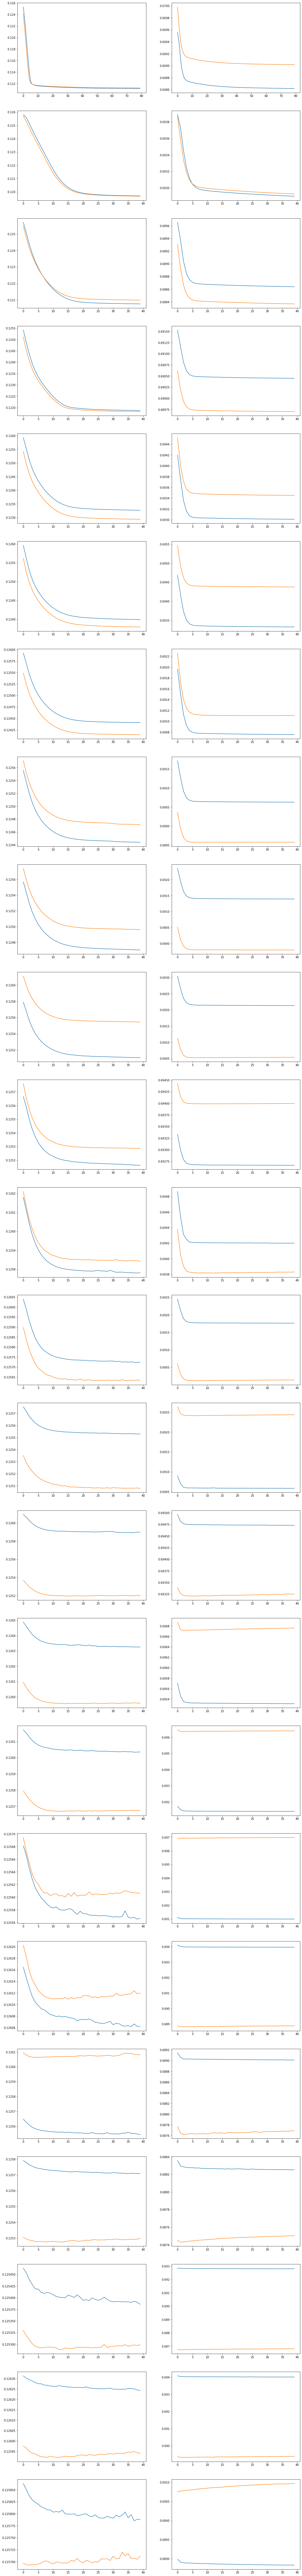

In [22]:
fig,ax = plt.subplots( of_niter, 2, figsize=(18,7*of_niter))

for ofi in range(0,of_niter) :
    
    ax[ofi][0].plot( of_return_dict['train-hist-step1-iter%d' % ofi].history['loss']  )
    ax[ofi][0].plot( of_return_dict['train-hist-step1-iter%d' % ofi].history['val_loss']  )

    ax[ofi][1].plot( of_return_dict['train-hist-step2-iter%d' % ofi].history['loss']  )
    ax[ofi][1].plot( of_return_dict['train-hist-step2-iter%d' % ofi].history['val_loss']  )
    



<function matplotlib.pyplot.show(close=None, block=None)>

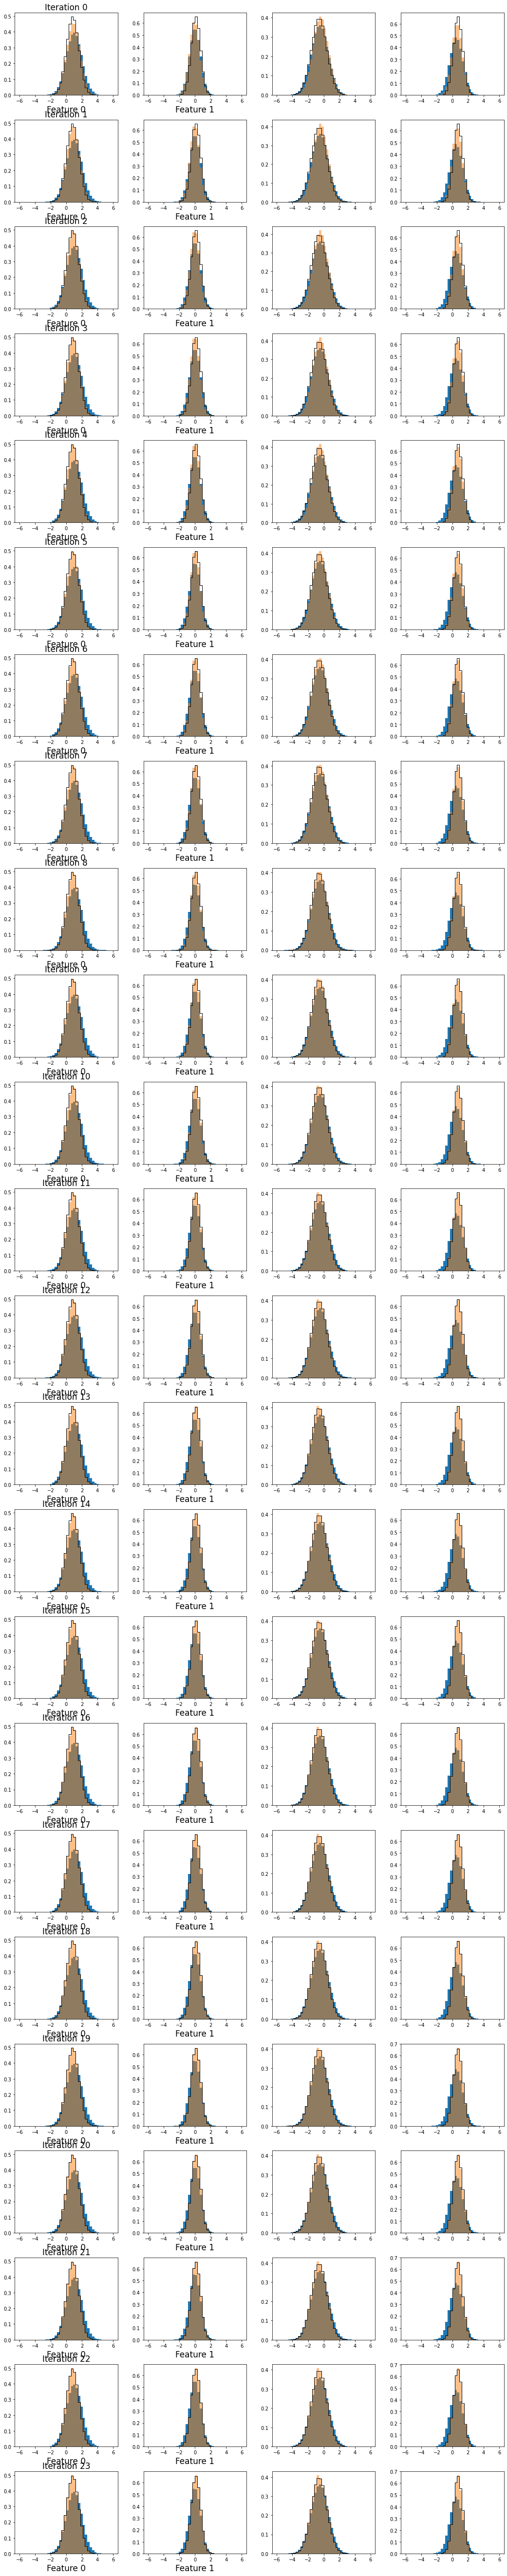

In [23]:


fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            ax[ofi][di].hist( train_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            hist_data_mc_ofweighted[ofi,di],_,_ = ax[ofi][di].hist( train_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            hist_data_truth[ofi,di],_,_ =         ax[ofi][di].hist( true_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )


    else :
        
        for di in range(ndim) :

        
            hist_data_mc_ofweighted[ofi,di],_,_ = ax[ofi][di].hist( train_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            hist_data_truth[ofi,di],_,_ =         ax[ofi][di].hist( true_pts[:,di], bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [24]:
hist_data_diff = hist_data_mc_ofweighted - hist_data_truth
hist_data_diff2 = hist_data_diff * hist_data_diff

hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        hist_data_sum_diff2[ofi,di] = np.sum( hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

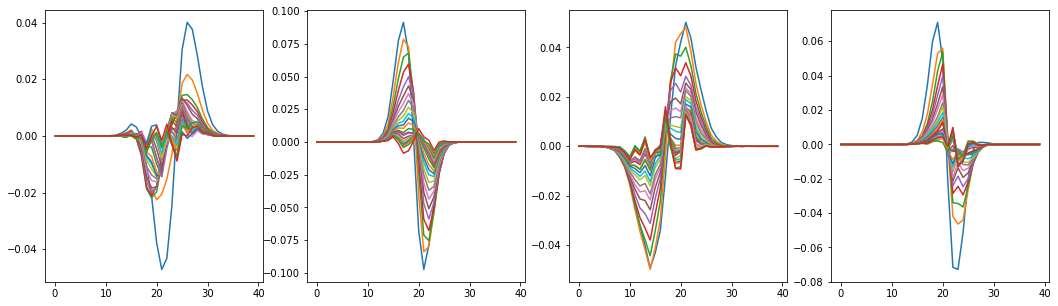

In [25]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        ax[di].plot(hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

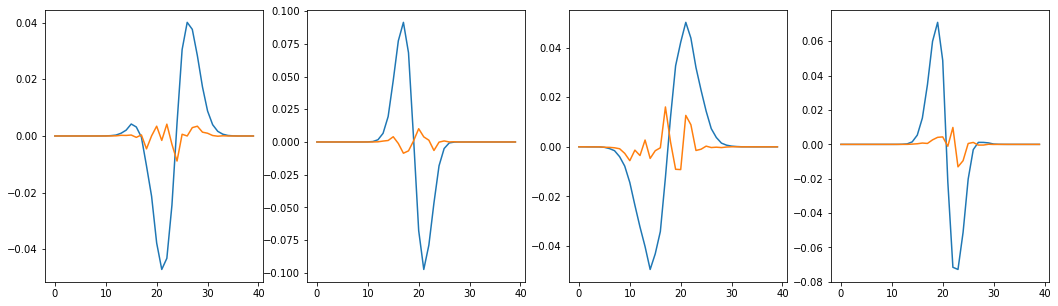

In [26]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    ax[di].plot(hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    ax[di].plot(hist_data_diff[ofi,di])

    
plt.show  

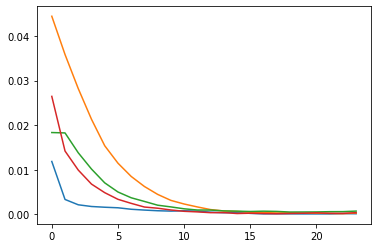

In [27]:
plt.plot( hist_data_sum_diff2)

<function matplotlib.pyplot.show(close=None, block=None)>

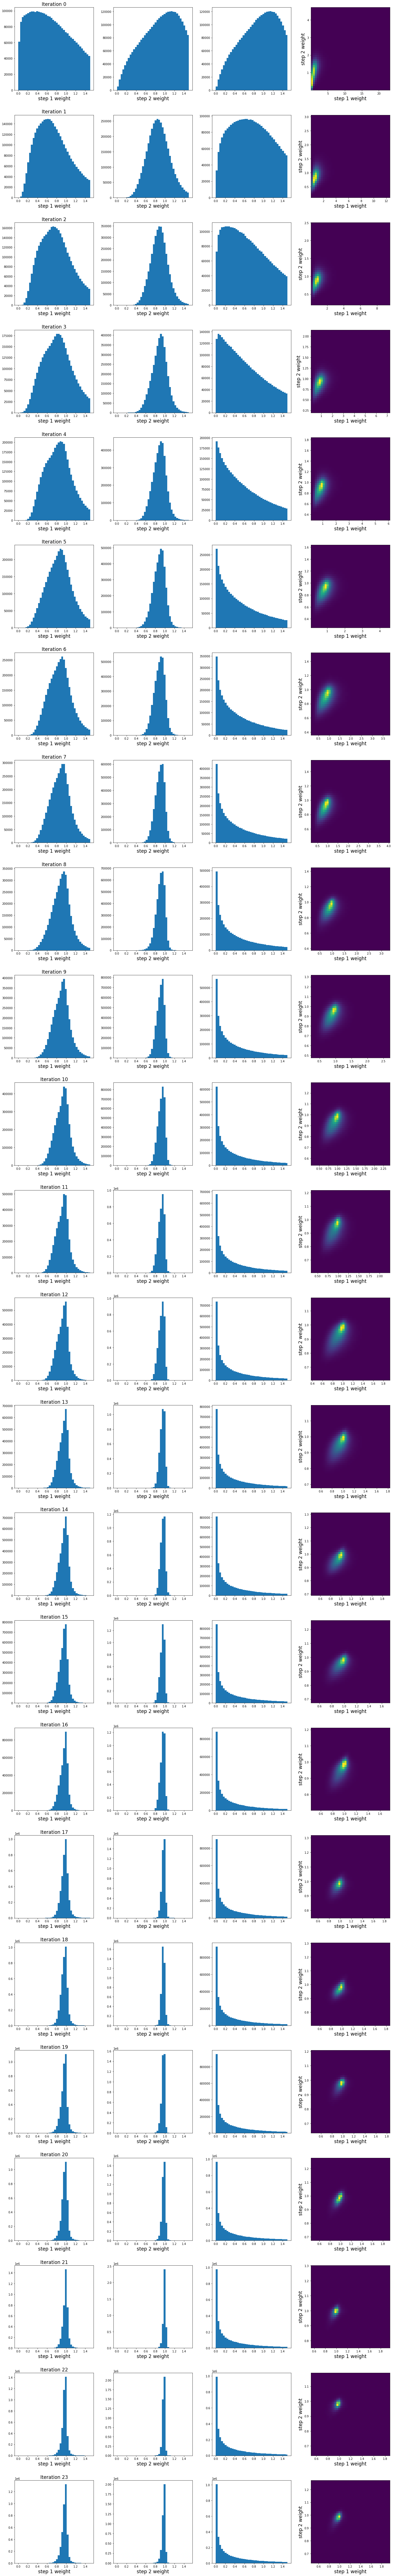

In [28]:
fig,ax = plt.subplots( of_niter, 4, figsize=(24,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist( of_weights[ofi,0,:], bins=hbins, range=[0.,1.5] )
    ax[ofi][1].hist( of_weights[ofi,1,:], bins=hbins, range=[0.,1.5] )
    ax[ofi][2].hist( push_weights[ofi,:], bins=hbins, range=[0.,1.5] )
    ax[ofi][3].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][3].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    ax[ofi][3].set_ylabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

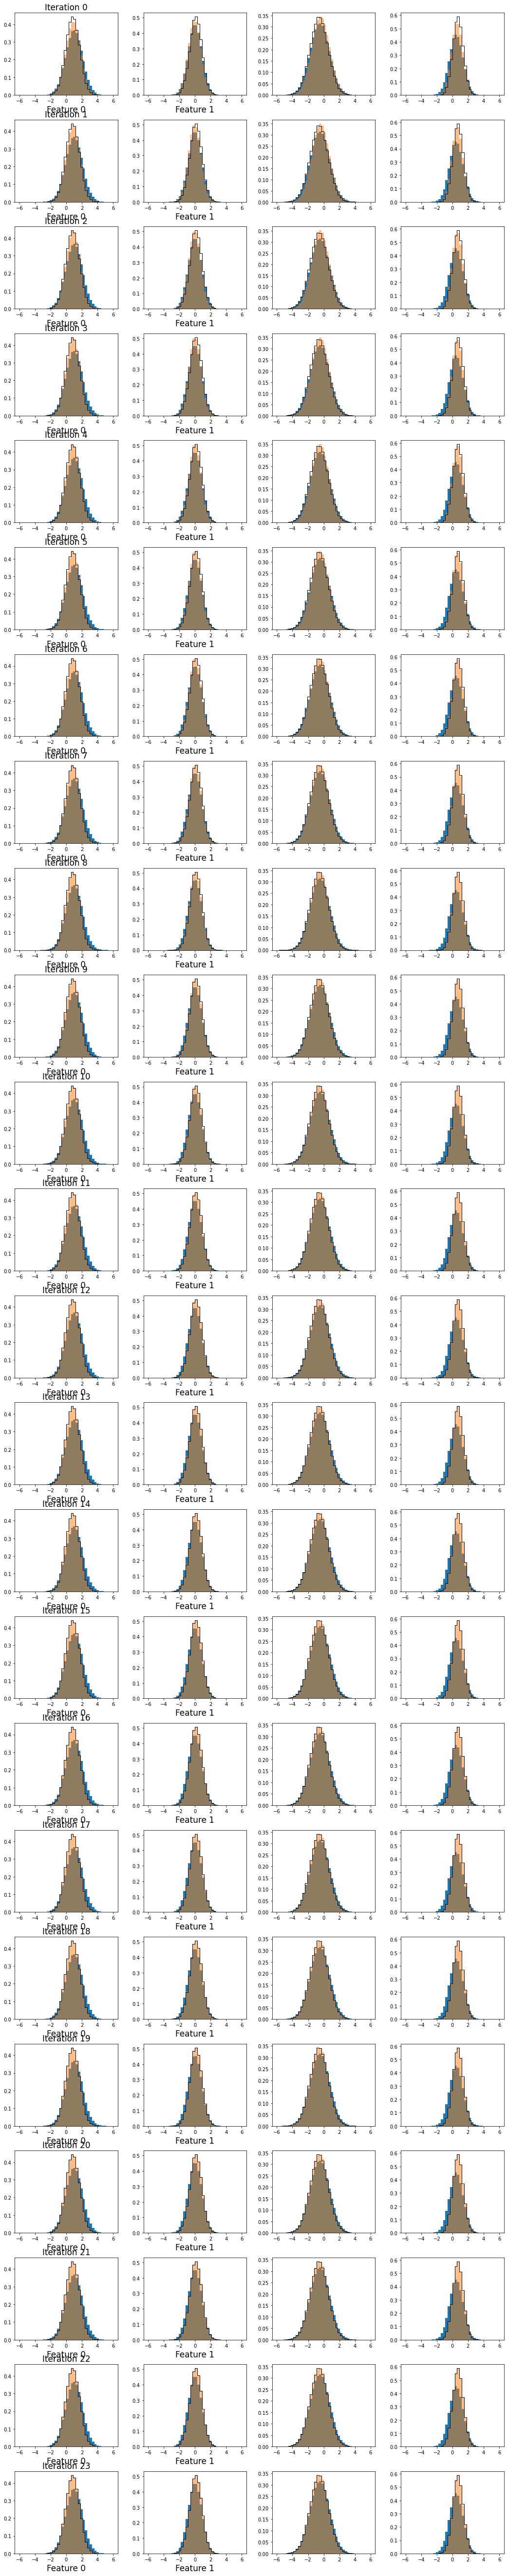

In [29]:

fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

det_hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
det_hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            ax[ofi][di].hist( train_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            det_hist_data_mc_ofweighted[ofi,di],_,_ = ax[ofi][di].hist( train_det_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         ax[ofi][di].hist( true_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )


    else :
        
        for di in range(ndim) :

        
            det_hist_data_mc_ofweighted[ofi,di],_,_ = ax[ofi][di].hist( train_det_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         ax[ofi][di].hist( true_det_pts[:,di], bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [30]:
det_hist_data_diff = det_hist_data_mc_ofweighted - det_hist_data_truth
det_hist_data_diff2 = det_hist_data_diff * det_hist_data_diff

det_hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        det_hist_data_sum_diff2[ofi,di] = np.sum( det_hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

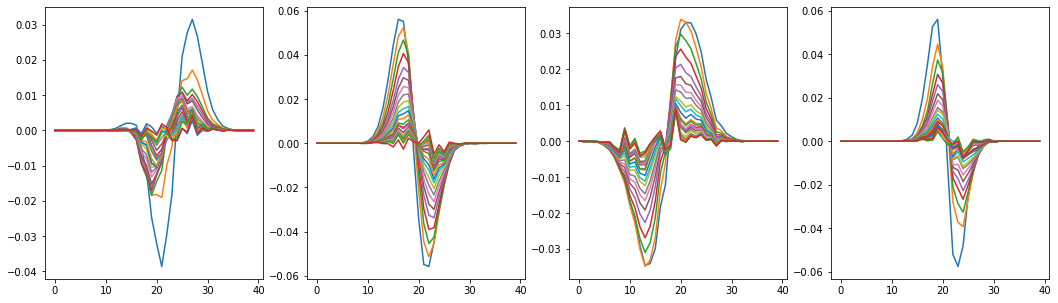

In [31]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        ax[di].plot(det_hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

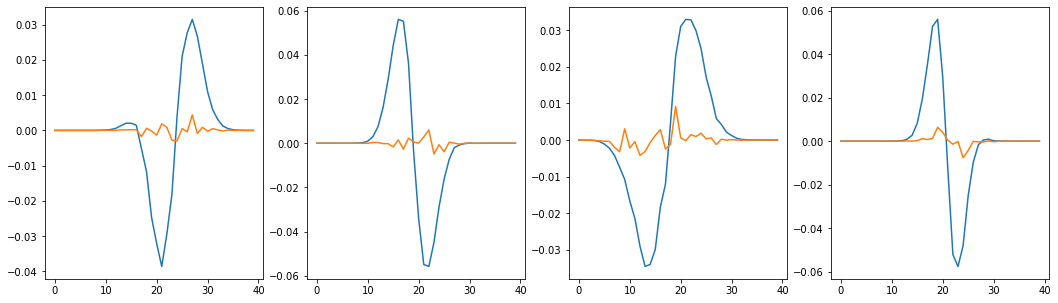

In [32]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    ax[di].plot(det_hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    ax[di].plot(det_hist_data_diff[ofi,di])

    
plt.show  

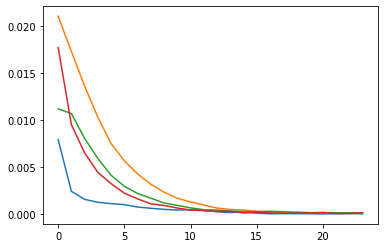

In [33]:
plt.plot( det_hist_data_sum_diff2)

In [34]:
step1_mean = np.zeros( of_niter )
step1_rms = np.zeros( of_niter )

step2_mean = np.zeros( of_niter )
step2_rms = np.zeros( of_niter )

iter_val = np.zeros( of_niter )

for ofi in range( of_niter ) :
    
    iter_val[ofi] = ofi
    
    step1_mean[ofi] = np.mean( of_weights[ofi,0,:] )
    step1_rms[ofi] = np.sqrt( np.var( of_weights[ofi,0,:]))
    
    step2_mean[ofi] = np.mean( of_weights[ofi,1,:] )
    step2_rms[ofi] = np.sqrt( np.var( of_weights[ofi,1,:]))
    
    print("  iter %2d : step 1 mean  %.3f  rms %.3f      step 2 mean  %.3f  rms %.3f" % 
          (ofi, step1_mean[ofi], step1_rms[ofi], step2_mean[ofi], step2_rms[ofi]) )

  iter  0 : step 1 mean  1.018  rms 0.901      step 2 mean  1.018  rms 0.468
  iter  1 : step 1 mean  0.879  rms 0.584      step 2 mean  0.879  rms 0.247
  iter  2 : step 1 mean  0.889  rms 0.477      step 2 mean  0.887  rms 0.184
  iter  3 : step 1 mean  0.893  rms 0.414      step 2 mean  0.891  rms 0.161
  iter  4 : step 1 mean  0.889  rms 0.348      step 2 mean  0.886  rms 0.138
  iter  5 : step 1 mean  0.883  rms 0.304      step 2 mean  0.881  rms 0.126
  iter  6 : step 1 mean  0.886  rms 0.261      step 2 mean  0.885  rms 0.111
  iter  7 : step 1 mean  0.895  rms 0.235      step 2 mean  0.893  rms 0.098
  iter  8 : step 1 mean  0.904  rms 0.209      step 2 mean  0.906  rms 0.091
  iter  9 : step 1 mean  0.906  rms 0.181      step 2 mean  0.906  rms 0.079
  iter 10 : step 1 mean  0.925  rms 0.161      step 2 mean  0.924  rms 0.073
  iter 11 : step 1 mean  0.921  rms 0.141      step 2 mean  0.922  rms 0.064
  iter 12 : step 1 mean  0.924  rms 0.127      step 2 mean  0.925  rms 0.063

<function matplotlib.pyplot.show(close=None, block=None)>

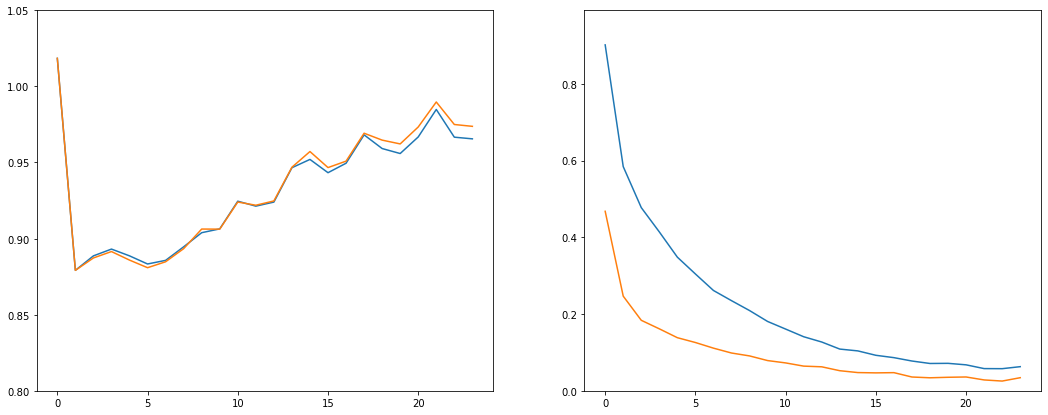

In [35]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))

ax[0].plot( iter_val, step1_mean )
ax[0].plot( iter_val, step2_mean )
ax[0].set_ylim( 0.80, 1.05)

ax[1].plot( iter_val, step1_rms )
ax[1].plot( iter_val, step2_rms )
ax[1].set_ylim( 0, 1.1*np.max(step1_rms))


plt.show